In [2]:
import getpass
import os
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

# 1. Chat model loading

Using a local open-source model in gguf format downloaded from HF. (**mixedbread-ai/mxbai-embed-large-v1**) It is a very small model with only 0.3B parameters (3-4 minutes to download on a Macbook)

This model has been chosen over two filters:
- Models with less than 3B parameters
- The ones supporting GGUF formats 
- The most downloaded model among the filtered ones

In [3]:
# Path to the model
local_model = "/Users/nayeongkim/Desktop/ML/localLLM/mxbai-embed-large-v1-f16.gguf"

In [4]:
import llama_cpp

In [5]:
import multiprocessing
from langchain_community.chat_models import ChatLlamaCpp

llm = ChatLlamaCpp(
    temperature=0.5,
    model_path=local_model,
    n_ctx=10000,
    n_gpu_layers=8,
    n_batch=300,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    max_tokens=512,
    n_threads=multiprocessing.cpu_count() - 1,
    repeat_penalty=1.5,
    top_p=0.5,
    verbose=True,
)

llama_model_load_from_file_impl: using device Metal (Apple M4 Pro) - 36863 MiB free
llama_model_loader: loaded meta data with 23 key-value pairs and 389 tensors from /Users/nayeongkim/Desktop/ML/localLLM/mxbai-embed-large-v1-f16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = bert
llama_model_loader: - kv   1:                               general.name str              = mxbai-embed-large-v1
llama_model_loader: - kv   2:                           bert.block_count u32              = 24
llama_model_loader: - kv   3:                        bert.context_length u32              = 512
llama_model_loader: - kv   4:                      bert.embedding_length u32              = 1024
llama_model_loader: - kv   5:                   bert.feed_forward_length u32              = 4096
llama_model_loader: - kv   6:                 

Didn't work out using LLM from CHATLlamaCPP format of GGUF model. Works okay the indexing and vectorizing part and the LLM invoking part using Llamafile.

In [22]:
from langchain_community.llms.llamafile import Llamafile

llm = Llamafile()

ggml_metal_free: deallocating
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)
ggml_metal_mem_pool_free: freeing memory pool, num heaps = 0 (total = 0)


# 2. Embedding loading

I'll use a small embedding, loading it directly from HuggingFace. (30 seconds)

In [23]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 3. Indexing system

I chose Chroma, since I had a good experience of it using it directly from **ChromaDB** package.

In [24]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [25]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [26]:
print(docs[0].page_content[:300])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as i


In [27]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [28]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['35995281-bf12-4558-8d14-d1ea71bda77a', 'b65a56f0-599d-47f9-9e0d-e6456d244ff5', 'a3f53934-02ec-476f-ba09-a3afd9d8d057']


In [29]:
from langchain import hub
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [30]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [31]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

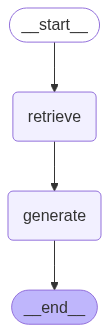

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
question = "What is Task Decomposition?"
retrieved_docs = vector_store.similarity_search(question)
retrieved_docs

[Document(id='f369cf95-9f8a-40d5-8e00-98e91ac04f5d', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [34]:
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
docs_content

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#\n\nTask 

In [35]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [36]:
prompt = prompt.invoke({"question": question, 
                        "context": docs_content})

In [21]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [37]:
answer = llm.invoke(prompt)

In [40]:
import pprint as p
p.pprint(answer)

(' \n'
 'Task decomposition involves breaking down a complex task into smaller '
 'subtasks that can be executed independently using existing resources. This '
 'approach is particularly useful when the goal is to develop a new robotic '
 'system that can accomplish specific tasks with limited resources (e.g., a '
 'mobile robot) or adapt quickly to changing requirements. In this context, '
 'LLM can help by providing natural language instructions for the subtasks, '
 'allowing an external classical planner to generate a plan based on those '
 'instructions. This process outsources the planning step and allows the '
 'system to focus on other critical aspects, such as controlling the robot or '
 'interacting with its environment. Another approach to task decomposition is '
 'to use a classical planner that generates a PDDL plan based on an existing '
 '"Domain PDDL". While this approach can also provide natural language '
 'instructions for the subtasks, it requires a pre-existing doma